# LIME and its Variants Tutorials

LIME, Local Interpretable Model-agnostic Explanation, presents a locally faithful explanation by fitting a set of perturbed samples near the target sample using a potentially interpretable model, such as linear models and decision trees. 

LIME is a local explanation. This means that the explanation is probably different for different target samples. In contrast, the global explanation is for the model, so it does not change across samples. Local explanations are of advantages over global ones for deep networks. Because there are many neurons and decision paths in the complex deep neural network, for each sample, the model may have different activated neurons so the reasons for making the final decisions are different.

LIME is a model-agnostic explanation. This means that the method does not depend on any property of the model. In fact, as long as the prediction function is given, LIME is applicable.

The idea of LIME is, for one specific target sample, first to perturb the input features, compute the responses of the original model, and finally obtain the (linear) relation between perturbed inputs and the corresponded outputs. The obtained linear weights are considered as feature importance for the target sample.

Different from input gradient based methods, LIME's explanations are class discriminative. This means that the explanation results are quite different if the class desired to interpret is different. Let's say, for an image of two objects, LIME produces two different explanations for the two classes respectively. We use such a case for this tutorial, for example:

![](./assets/catdog.png)

In this tutorial, we introduce the implementation details of [LIME](https://github.com/PaddlePaddle/InterpretDL/blob/master/interpretdl/interpreter/lime.py) and how to use it in practice. 

In [1]:
import interpretdl as it
import paddle
device = 'gpu:0'
paddle.set_device(device)

print("Loading pretrained model.")
from paddle.vision.models import mobilenet_v2
paddle_model = mobilenet_v2(pretrained=True)

Loading pretrained model.


W0520 15:42:32.850314 13048 gpu_context.cc:278] Please NOTE: device: 0, GPU Compute Capability: 7.0, Driver API Version: 11.2, Runtime API Version: 10.2
W0520 15:42:32.856264 13048 gpu_context.cc:306] device: 0, cuDNN Version: 7.6.


LIME for the dog


100%|██████████| 3000/3000 [00:19<00:00, 155.68it/s]


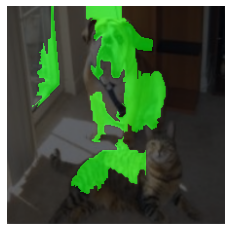

LIME for the cat


100%|██████████| 3000/3000 [00:19<00:00, 155.87it/s]


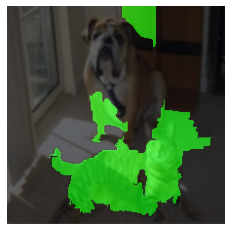

In [5]:
img_path = 'assets/catdog.png'
print("LIME for the dog")
algo = it.LIMECVInterpreter(paddle_model, device=device)
lime_explanation = algo.interpret(img_path, num_samples=3000, batch_size=100, interpret_class=246)

print("LIME for the cat")
algo = it.LIMECVInterpreter(paddle_model, device=device)
lime_explanation = algo.interpret(img_path, num_samples=3000, batch_size=100, interpret_class=282)

## Classifying Images

The process is the same as in [Getting Started Tutorial](https://github.com/PaddlePaddle/InterpretDL/blob/master/tutorials/Getting_Started.ipynb).

In [6]:
import interpretdl as it
import paddle
device = 'gpu:0'
paddle.set_device(device)

print("Loading pretrained model.")
from paddle.vision.models import mobilenet_v2
paddle_model = mobilenet_v2(pretrained=True)
paddle_model.eval()

img_path = 'assets/catdog.png'
img, data = it.data_processor.readers.images_transform_pipeline(img_path)

# !wget -c https://github.com/PaddlePaddle/InterpretDL/files/8561411/readable_label.txt -P ./assets/
f = open('assets/readable_label.txt', 'r')
lines = f.readlines()

# see the predicted top 5 probabilites
probability = paddle.nn.Softmax()(paddle_model(paddle.to_tensor(data)))
topvalues, top_ids = paddle.topk(probability, 5)

print('The model gives the predictions as follows:')
for cls_prob, cls_id in zip(topvalues[0].numpy(), top_ids[0].numpy()):
    print(f'\tprobability: {cls_prob:.5f} ({lines[cls_id].strip()})')

Loading pretrained model.
The model gives the predictions as follows:
	probability: 0.63782 (292 tiger, Panthera tigris)
	probability: 0.31042 (282 tiger cat)
	probability: 0.02200 (246 Great Dane)
	probability: 0.01085 (281 tabby, tabby cat)
	probability: 0.00617 (243 bull mastiff)


## LIME

The three important arguments for `LIME` are `interpret_class`, `num_samples` and `batch_size`. 
```python
"""
    interpret_class (int, optional): The index of class to interpret. If None, the most likely label will be 
        used. Default: ``None``.
    num_samples (int, optional): LIME sampling numbers. Larger number of samples usually gives more accurate 
        interpretation. Default: ``1000``.
    batch_size (int, optional): Number of samples to forward each time. Default: ``50``.
"""
```

- `interpret_class` is the class index to be interpreted.
- `num_samples` is the number of perturbed samples for the linear regression.
- `batch_size` is the batch size for passing the model each time. It does not affect the explanation results but the computation time.

We show how each of them affects the explanations.

### interpret_class

In fact, `interpret_class` is already shown in the beginning of this tutorial. We jump this part. Readers can try more examples with varying the `interpret_class`.

### num_samples

LIME with num_samples 10
LIME for the dog


100%|██████████| 10/10 [00:00<00:00, 380.93it/s]
/opt/conda/envs/pp2/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:188: LinAlgWarning: Ill-conditioned matrix (rcond=1.62394e-18): result may not be accurate.
  overwrite_a=False)


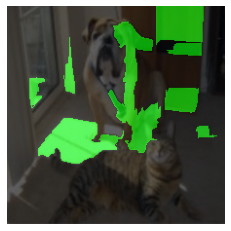

LIME for the cat


100%|██████████| 10/10 [00:00<00:00, 391.83it/s]
/opt/conda/envs/pp2/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:188: LinAlgWarning: Ill-conditioned matrix (rcond=5.13457e-18): result may not be accurate.
  overwrite_a=False)


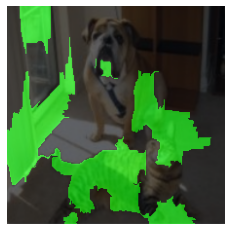

LIME with num_samples 500
LIME for the dog


100%|██████████| 500/500 [00:03<00:00, 154.10it/s]


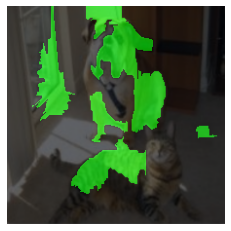

LIME for the cat


100%|██████████| 500/500 [00:03<00:00, 154.92it/s]


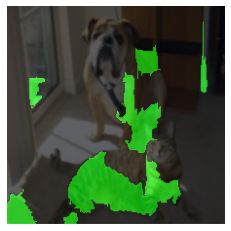

LIME with num_samples 3000
LIME for the dog


100%|██████████| 3000/3000 [00:19<00:00, 154.90it/s]


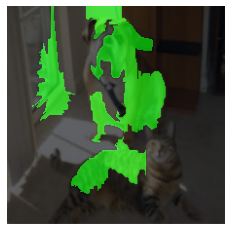

LIME for the cat


100%|██████████| 3000/3000 [00:19<00:00, 150.50it/s]


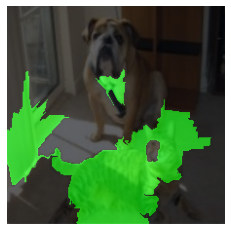

LIME with num_samples 10000
LIME for the dog


100%|██████████| 10000/10000 [01:06<00:00, 150.22it/s]


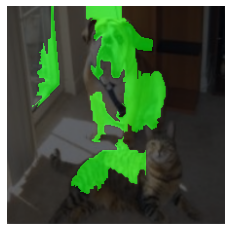

LIME for the cat


100%|██████████| 10000/10000 [01:06<00:00, 151.27it/s]


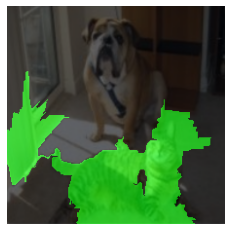

In [7]:

for num_samples in [10, 500, 3000, 10000]:
    print("========================================")
    print("LIME with num_samples", num_samples)
    print("LIME for the dog")
    algo = it.LIMECVInterpreter(paddle_model, device=device)
    lime_explanation = algo.interpret(img_path, num_samples=num_samples, batch_size=100, interpret_class=246)

    print("LIME for the cat")
    algo = it.LIMECVInterpreter(paddle_model, device=device)
    lime_explanation = algo.interpret(img_path, num_samples=num_samples, batch_size=100, interpret_class=282)
    

As we can see, when `num_samples` = 10, there are many noises in the explanation results and a warning from linear regression (Ill-conditioned matrix (rcond=1.62394e-18): result may not be accurate.) is raised.

When `num_samples` = 500, the noises are reduced a lot and very similar to the explanations when `num_samples` = 3000 and `num_samples` = 10000.

Moreover, we can see that the time cost is almost linearly related to the `num_samples`. This has also been indicated in the LIME paper. This is because the network forward time is the large part for the time cost, while the linear regression is negligible.

### batch_size
`batch_size` does not affect the explanation results, but may have impact on the time cost. This is because of the parallel computation of GPU cores. Let's see some results.

LIME with batch_size 2
LIME for the cat


100%|██████████| 3000/3000 [00:39<00:00, 76.26it/s]


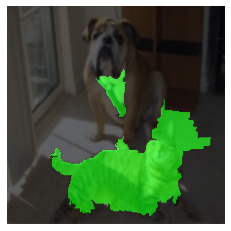

LIME with batch_size 5
LIME for the cat


100%|██████████| 3000/3000 [00:25<00:00, 115.89it/s]


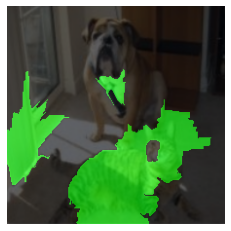

LIME with batch_size 10
LIME for the cat


100%|██████████| 3000/3000 [00:21<00:00, 140.40it/s]


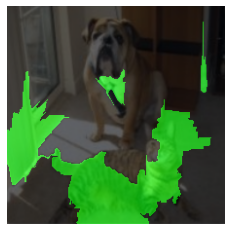

LIME with batch_size 50
LIME for the cat


100%|██████████| 3000/3000 [00:17<00:00, 168.82it/s]


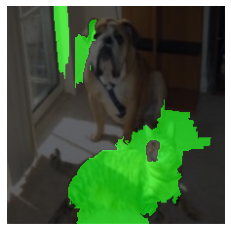

LIME with batch_size 100
LIME for the cat


100%|██████████| 3000/3000 [00:19<00:00, 150.17it/s]


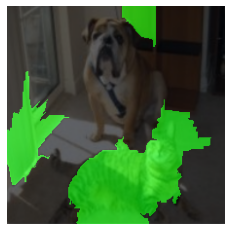

In [9]:

for batch_size in [2, 5, 10, 50, 100]:
    print("========================================")
    print("LIME with batch_size", batch_size)
    
    print("LIME for the cat")
    algo = it.LIMECVInterpreter(paddle_model, device=device)
    lime_explanation = algo.interpret(img_path, num_samples=3000, batch_size=batch_size, interpret_class=282)
    

We summarize a little: 

| batch size | time cost |
|------------|-----------|
| 2          | 39s       |
| 5          | 25s       |
| 10         | 21s       |
| 50         | 17s       |
| 100        | 19s       |

As we can see, when the batch size is too small, it would cost much time due to the small usage of GPU cores. However, when the batch size is large, it still increases a little time. This correlation between batch size and time cost holds across models and devices, but the best choice of batch size may vary. So 50 is not always the best choice.

## Next Step

This is the first part of `LIME and Its Variants`. In this tutorial, we only introduced LIME on the vision task. 

Note that LIME can be applied to any differentiable models and any tasks, not limited in visual recognition. We have also the tutorials of NLP tasks, using 
[Ernie2.0 in English](https://github.com/PaddlePaddle/InterpretDL/blob/master/tutorials/ernie-2.0-en-sst-2.ipynb) ([on NBViewer](https://nbviewer.org/github/PaddlePaddle/InterpretDL/blob/master/tutorials/ernie-2.0-en-sst-2.ipynb)), 
[Bert in English](https://github.com/PaddlePaddle/InterpretDL/blob/master/tutorials/bert-en-sst-2.ipynb) ([on NBViewer](https://nbviewer.org/github/PaddlePaddle/InterpretDL/blob/master/tutorials/bert-en-sst-2.ipynb)), 
[BiLSTM in Chinese](https://github.com/PaddlePaddle/InterpretDL/blob/master/tutorials/bilstm-zh-chnsenticorp.ipynb) ([on NBViewer](https://nbviewer.org/github/PaddlePaddle/InterpretDL/blob/master/tutorials/bilstm-zh-chnsenticorp.ipynb)) and 
[Ernie1.0 in Chinese](https://github.com/PaddlePaddle/InterpretDL/blob/master/tutorials/ernie-1.0-zh-chnsenticorp.ipynb) ([on NBViewer](https://nbviewer.org/github/PaddlePaddle/InterpretDL/blob/master/tutorials/ernie-1.0-zh-chnsenticorp.ipynb)) as examples. For text visualizations, NBViewer gives better and colorful rendering results.

The next part of `LIME and Its Variants` would focus on the variants of LIME, such as [LIME-Prior](https://github.com/PaddlePaddle/InterpretDL/blob/master/interpretdl/interpreter/lime_prior.py) and [NormLIME](https://github.com/PaddlePaddle/InterpretDL/blob/master/interpretdl/interpreter/_normlime_base.py).